# Analysis of Dataset

## Preamble

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import csv
import os
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import MultipleLocator

from sklearn.preprocessing import MultiLabelBinarizer

In [3]:
import sys
sys.path.append('../src/')

import load_wdvd

In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

pd.set_option('display.width', 100)
pd.set_option('display.max_columns', 200)

## Load Data

In [5]:
PATH_FEATURES = '../../data/features/'

In [6]:
PATH_PROPERTY_DOMAINS = '../../data/property-domains/'

In [7]:
OUTPUT_DIR = '../../data/classification/'

### Load Dataframe

In [8]:
fields = ['revisionId', 'isEditingTool']

dtype = {
    'revisionId': np.int,
    'isEditingTool': np.bool,
    'subject': np.int,
    'predicate': np.int,
    'object': np.int,
    'superSubject': np.int,
    'superObject': np.int,
}

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    df_train = pd.read_csv(PATH_FEATURES + '/training/features.csv.bz2', index_col=0, usecols=fields, dtype=dtype)
    df_val = pd.read_csv(PATH_FEATURES + '/validation/features.csv.bz2', index_col=0, usecols=fields, dtype=dtype)
    df_test = pd.read_csv(PATH_FEATURES + '/test/features.csv.bz2', index_col=0, usecols=fields, dtype=dtype)

len(df_train)
len(df_val)
len(df_test)

24280578

1703987

2827193

In [9]:
(~df_train['isEditingTool']).sum()
(~df_val['isEditingTool']).sum()
(~df_test['isEditingTool']).sum()

5890968

550798

560524

### Load WDVD Features

In [10]:
df_wdvd = load_wdvd.load_df_wdvd()

### Load Domains / Predicate Groups

In [11]:
p_group_files = [x for x in os.listdir(PATH_PROPERTY_DOMAINS) if '.csv' in x]

In [12]:
p_groups = {}
for file in p_group_files:
    with open(PATH_PROPERTY_DOMAINS + file, 'r') as f:
        reader = csv.reader(f)
        p_groups.update({file[0:-4]: [int(x) for x in list(reader)[0]]})

In [13]:
property_mapping = {}
all_predicates = set(df_wdvd['property'].unique())

for p in all_predicates:
    for k in sorted(p_groups.keys()):
        if p in p_groups[k]:
            property_mapping.update({p: k})
            break

In [14]:
df_wdvd['propertyDomain'] =\
    [property_mapping[x] if x in property_mapping.keys() else '8_others' for x in df_wdvd['property']]

### Synchronize dataframes

In [15]:
usecols = df_wdvd.columns.difference(df_test.columns)
df_train = df_train.merge(df_wdvd[usecols], left_index=True, right_index=True)
df_val = df_val.merge(df_wdvd[usecols], left_index=True, right_index=True)
df_test = df_test.merge(df_wdvd[usecols], left_index=True, right_index=True)
df_all = pd.concat([df_train, df_val, df_test])

In [16]:
usecols = df_all.columns.difference(df_wdvd.columns)
df_wdvd = df_wdvd.merge(df_all[usecols], left_index=True, right_index=True, how='outer')

In [17]:
len(df_all)
len(df_wdvd)

28811758

82679918

In [18]:
df_all.head()

,isEditingTool,alphanumericRatio,asciiRatio,badWordRatio,bracketRatio,changeCount,commentCommentSimilarity,commentLabelSimilarity,commentLength,commentSitelinkSimilarity,commentTail,commentTailLength,containsLanguageWord,containsURL,contentType,cumUserUniqueItems,dataType,dataTypeFreq,digitRatio,englishAliases,englishDescription,englishLabel,englishSitelink,isAdminUser,isAdvancedUser,isBotUser,isCuratorUser,isHuman,isLatinLanguage,isLivingPerson,isPrivilegedUser,isRegisteredUser,itemFreq,itemId,itemValue,itemValueFreq,languageWordRatio,latinRatio,literalValue,literalValueFreq,logCumItemUniqueUsers,logItemFreq,logItemId,logItemValue,longestCharacterSequence,longestWord,lowerCaseRatio,lowerCaseWordRatio,nonLatinRatio,numberOfAliases,numberOfBadges,numberOfDescriptions,numberOfLabels,numberOfProperties,numberOfQualifiers,numberOfReferences,numberOfSitelinks,numberOfStatements,param3,param4,positionWithinSession,property,propertyDomain,propertyFreq,proportionOfLanguageAdded,proportionOfLinksAdded,proportionOfQidAdded,punctuationRatio,revisionAction,revisionActionFreq,revisionLanguage,revisionLanguageFreq,revisionPrevAction,revisionPrevActionFreq,revisionSessionId,revisionSubaction,revisionSubactionFreq,revisionTags,revisionTagsFreq,rollbackReverted,timestamp,undoRestoreReverted,upperCaseRatio,upperCaseWordRatio,userCityFreq,userCityName,userContinentCode,userContinentFreq,userCountryCode,userCountryFreq,userCountyFreq,userCountyName,userFreq,userId,userName,userRegionCode,userRegionFreq,userSecondsSinceFirstRevision,userSecondsSinceFirstRevisionRegistered,userTimeZone,userTimeZoneFreq,whitespaceRatio
revisionId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
26780044,False,0.62,1.0,0.0,0.0,2.0,0.35,-1.00,61.0,-1.00,"[[Property:P107]], [[Q1969448]]",32.0,False,False,STATEMENT,4733,NaN,0.0,0.31,NaN,NaN,NaN,NaN,True,False,False,False,False,0.5,False,True,True,9.0,2864647,NaN,0.0,0.0,0.31,NaN,0.0,1,4.0,22.0,0.0,2.0,8.0,0.22,0.0,0.69,7,0,0,1,1,0,0,2,1,NaN,NaN,2,107.0,8_others,529270.0,0.0,0.0,0.0,0.31,wbcreateclaim,25045404.0,NaN,0.0,wbsetsitelink,5878139.0,26780004,create,31415438.0,NaN,0.0,False,2013-04-18 17:17:54+00:00,False,0.09,0.0,0.0,NaN,NaN,0.0,NaN,0.0,0.0,NaN,215363,91742,Andreasmperu,NaN,0.0,4970873,4970873,NaN,0.0,0.06
26787013,False,0.61,1.0,0.0,0.0,2.0,0.00,0.39,60.0,0.39,"[[Property:P107]], [[Q386724]]",31.0,False,False,STATEMENT,2533,NaN,0.0,0.29,NaN,NaN,Omar Killed Me,Omar Killed Me,False,False,False,False,False,0.5,False,False,True,14.0,3351917,NaN,0.0,0.0,0.32,NaN,0.0,1,4.0,22.0,0.0,2.0,8.0,0.23,0.0,0.68,2,0,0,3,2,0,1,4,2,NaN,NaN,2,107.0,8_others,529270.0,0.0,0.0,0.0,0.32,wbcreateclaim,25045404.0,NaN,0.0,wbsetsitelink,5878139.0,26786977,create,31415438.0,NaN,0.0,False,2013-04-18 17:43:50+00:00,False,0.10,0.0,0.0,NaN,NaN,0.0,NaN,0.0,0.0,NaN,1173043,13330,Coyau,NaN,0.0,12336338,12336338,NaN,0.0,0.06
26787021,False,0.59,1.0,0.0,0.0,2.0,0.91,0.39,58.0,0.39,"[[Property:P31]], [[Q11424]]",29.0,False,False,STATEMENT,2533,wikibase-item,26280788.0,0.24,NaN,NaN,Omar Killed Me,Omar Killed Me,False,False,False,False,False,0.5,False,False,True,14.0,3351917,NaN,0.0,0.0,0.34,NaN,0.0,1,4.0,22.0,0.0,2.0,8.0,0.24,0.0,0.66,2,0,0,3,3,0,1,4,3,NaN,NaN,3,31.0,1_generic,5943610.0,0.0,0.0,0.0,0.34,wbcreateclaim,25045404.0,NaN,0.0,wbcreateclaim,20533056.0,26786977,create,31415438.0,NaN,0.0,False,2013-04-18 17:43:51+00:00,False,0.10,0.0,0.0,NaN,NaN,0.0,NaN,0.0,0.0,NaN,1173043,13330,Coyau,NaN,0.0,12336339,12336339,NaN,0.0,0.07
26794656,False,0.61,1.0,0.0,0.0,2.0,0.31,0.00,60.0,0.00,"[[Property:P47]], [[Q1579380]]",31.0,False,False,STATEMENT,40,wikibase-item,26280788.0,0.29,NaN,"municipality in Casanare, Colombia",Yopal,Yopal,False,False,False,False,False,0.5,False,False,True,57.0,13591,NaN,0.0,0.0,0.32,NaN,0.0,3,6.0,14.0,0.0,2.0,8.0,0.23,0.0,0.68,1,0,4,25,4,0,0,26,9,NaN,NaN,6,47.0,7_place,136883.0,0.0,0.0,0.0,0.32,wbcreateclaim,25045404.0,NaN,0.0,NaN,0.0,25247759,create,31415438.0,NaN,0.0,Fa

## Dataset Construction

In [19]:
def dataset_construction(df):
    linkRegex       = '\[\[Property:P\d*\]\].*\[\[Q\d*\]\].*'
    revisionActions = ['wbcreateclaim', 'wbsetclaim', 'wbremoveclaims', 'wbsetclaimvalue']

    A = ~(df['revisionTags'].str.contains('OAuth') | df['revisionTags'].str.contains('HHVM'))
    B = df['contentType'] != 'TEXT'                                  # Exclude labels, descriptions, aliases
    C = df['contentType'] != 'SITELINK'                              # Exclude sitelinks
    D = (df['revisionAction'].isin(revisionActions) |                # Exclude references and qualifiers
         (df['contentType'] == 'MISC'))
    E = (df['commentTail'].str.contains(linkRegex).fillna(False) |   # Exclude attributes
         (df['contentType'] == 'MISC'))
    F = df['contentType'] != 'MISC'                                  # Exclude misc (e.g. item merges)

    def get_statistics(df, index):
        df_result = pd.DataFrame()
        df_result.loc[index, 'revisions'] = len(df)
        return df_result

    statistics = pd.DataFrame()
    statistics = statistics.append(get_statistics(df, 'WDVC-2016'))
    statistics = statistics.append(get_statistics(df[A], 'w/o semi-automatic editing tools'))
    statistics = statistics.append(get_statistics(df[A & B], 'w/o labels, descriptions, aliases'))
    statistics = statistics.append(get_statistics(df[A & B & C], 'w/o sitelinks'))
    statistics = statistics.append(get_statistics(df[A & B & C & D], 'w/o qualifiers, references'))
    statistics = statistics.append(get_statistics(df[A & B & C & D & E], 'w/o attributes'))
    statistics = statistics.append(get_statistics(df[A & B & C & D & E & F], 'w/o item creation, merges, misc'))
    statistics['revisions'] = statistics['revisions'].astype(np.int)

    statistics['proportion'] = statistics / statistics.iloc[0]
    return statistics

In [20]:
df_dataset_construction = dataset_construction(df_wdvd)

In [21]:
formatters = {
    'revisions': '{:,.0f}'.format,
    'proportion': '{:.0%}'.format
}

df_dataset_construction.to_latex(OUTPUT_DIR + 'table-dataset-construction.tex', formatters=formatters)
df_dataset_construction.style.format(formatters)

,revisions,proportion
WDVC-2016,"82,679,918",100%
w/o semi-automatic editing tools,"35,462,023",43%
"w/o labels, descriptions, aliases","26,959,949",33%
w/o sitelinks,"17,371,199",21%
"w/o qualifiers, references","15,883,276",19%
w/o attributes,"11,631,335",14%
"w/o item creation, merges, misc","7,002,290",8%


## Dataset Split

In [22]:
def split_statistics_df(df, index):
    statistics = pd.DataFrame()

    statistics.loc[index, 'From'] = df['timestamp'].min()
    statistics.loc[index, 'To'] = df['timestamp'].max()
    statistics.loc[index, 'Vand.'] = df['rollbackReverted'].sum()
    statistics.loc[index, 'Revisions'] = df.index.nunique()
    statistics.loc[index, 'Subjects'] = df['itemId'].nunique()
    statistics.loc[index, 'Predicates'] = df['property'].nunique()
    statistics.loc[index, 'Objects'] = df['itemValue'].nunique()

    return statistics

In [23]:
def split_statistics(df_train, df_val, df_test):
    statistics = pd.DataFrame()
    statistics = statistics.append(split_statistics_df(df_train, 'Training'))
    statistics = statistics.append(split_statistics_df(df_val, 'Validation'))
    statistics = statistics.append(split_statistics_df(df_test, 'Test'))
    return statistics

In [24]:
mask_nosat_train = ~df_train['isEditingTool'].values.astype(np.bool)
mask_nosat_val   = ~df_val['isEditingTool'].values.astype(np.bool)
mask_nosat_test  = ~df_test['isEditingTool'].values.astype(np.bool)
mask_nosat_all   = ~df_all['isEditingTool'].values.astype(np.bool)

In [25]:
statistics = split_statistics(df_train[mask_nosat_train], df_val[mask_nosat_val], df_test[mask_nosat_test])

formatters = {
    'From': '{:%b %d, %Y}'.format,
    'To': '{:%b %d, %Y}'.format,
    'Vand.': '{:,.0f}'.format,
    'Revisions': '{:,.0f}'.format,
    'Subjects': '{:,.0f}'.format,
    'Predicates': '{:,.0f}'.format,
    'Objects': '{:,.0f}'.format
}
statistics.to_latex(OUTPUT_DIR + 'table-dataset-split.tex', formatters=formatters)
statistics.style.format(formatters)

,From,To,Vand.,Revisions,Subjects,Predicates,Objects
Training,"Apr 18, 2013","Feb 29, 2016","16,608","5,890,968","2,187,993",747,"790,960"
Validation,"Mar 01, 2016","Apr 30, 2016","2,604","550,798","201,102",610,"131,666"
Test,"May 01, 2016","Jun 30, 2016","2,429","560,524","212,902",603,"131,479"


## Dataset by Domain

In [26]:
def domain_statistics(df):
    statistics = pd.DataFrame()
    statistics['total'] = df.groupby('propertyDomain')['rollbackReverted'].count()
    statistics['vand'] = df.groupby('propertyDomain')['rollbackReverted'].sum()
    statistics['vandProb'] = statistics['vand'] / statistics['total']

    df_benign = df[~df['rollbackReverted']].copy()
    df_benign['isUnregisteredUser'] = ~df_benign['isRegisteredUser']
    statistics['benignTotal'] = df_benign.groupby('propertyDomain')['rollbackReverted'].count()
    statistics['benignUnreg'] = df_benign.groupby('propertyDomain')['isUnregisteredUser'].sum()
    statistics['benignUnregProb'] = statistics['benignUnreg'] / statistics['benignTotal']

    return statistics

In [27]:
statistics = domain_statistics(df_all[mask_nosat_all])

formatters = {
    'total': '{:,.0f}'.format,
    'vand': '{:,.0f}'.format,
    'vandProb': '{:.2%}'.format,
    'benignTotal': '{:,.0f}'.format,
    'benignUnreg': '{:,.0f}'.format,
    'benignUnregProb': '{:.2%}'.format
}

statistics.to_latex(OUTPUT_DIR + 'table-dataset-by-domain.tex', formatters=formatters)
statistics.style.format(formatters)

,total,vand,vandProb,benignTotal,benignUnreg,benignUnregProb
propertyDomain,,,,,,
1_generic,"1,863,273","5,755",0.31%,"1,857,518","36,174",1.95%
2_person,"1,905,257","10,539",0.55%,"1,894,718","46,671",2.46%
3_organization,"67,890",312,0.46%,"67,578","2,601",3.85%
4_events,"96,115",68,0.07%,"96,047",639,0.67%
5_works,"618,464","1,598",0.26%,"616,866","32,252",5.23%
6_terms,"680,904",437,0.06%,"680,467","2,279",0.33%
7_place,"951,589","1,628",0.17%,"949,961","16,857",1.77%
8_others,"818,798","1,304",0.16%,"817,494","13,841",1.69%


## Abuse Filter Rules

In [28]:
def binarize_tags(df):
    """Create one column per Tag."""
    mlb = MultiLabelBinarizer()
    # 'N' means NO_TAG (fillna does not work with strings or lists)
    df_mlb = pd.DataFrame(mlb.fit_transform(df['revisionTags'].str.split(',').fillna('N')), columns=mlb.classes_)
    display(mlb.classes_)

    # Summarize all columns unrelated to the abuse filter into one column
    no_rule_cols = \
        ['N', 'HHVM', 'mobile edit', 'mobile web edit', 'WE-Framework gadget', 'wikisyntax'] + \
        [col for col in mlb.classes_ if 'OAuth CID: ' in col]

    no_rule_cols = list(set(no_rule_cols).intersection(mlb.classes_))
    df_mlb['NO_RULE'] = (df_mlb[no_rule_cols].sum(axis=1) > 0)
    df_mlb.drop(no_rule_cols, axis=1, inplace=True)

    return df_mlb

In [29]:
def abuse_filter_rules(df):
    """Create Table with Statistics."""
    df_mlb = binarize_tags(df)

    df_result = pd.DataFrame()
    df_result['total'] = df_mlb.sum(axis=0).sort_values(ascending=False)

    mask = np.asarray(df['rollbackReverted'] == 1)
    df_result['vand'] = df_mlb[mask].sum(axis=0)

    mask = np.asarray(df['rollbackReverted'] == 0)
    df_result['benignTotal'] = df_mlb[mask].sum(axis=0)

    mask = np.asarray((df['rollbackReverted'] == 0) & (df['isRegisteredUser'] == 0))
    df_result['benignAnon'] = df_mlb[mask].sum(axis=0)

    user_rules = [
        'new editor changing statement',
        'new editor removing statement',
        'possible vandalism']
    df_result.loc['WITH_USER'] = df_result.loc[user_rules].sum()

    without_user_rules_misc = [
        'adding obsolete/deprecated property',
        'Unexpected value for entity type',
        'Unexpected value for IUCN conservation status',
        'Unexpected value for IMDb identifier',
        'adding language as label/description/alias']
    df_result.loc['WITHOUT_USER_MISC'] = df_result.loc[without_user_rules_misc].sum()

    without_user_rules = [
        'self-referencing',
        'removal of gender property',
        'Unexpected value for gender',
        'WITHOUT_USER_MISC']
    df_result.loc['WITHOUT_USER'] = df_result.loc[without_user_rules].sum()

    df_result['vandProb'] = df_result['vand'] / df_result['total']
    df_result['benignAnonProb'] = df_result['benignAnon'] / df_result['benignTotal']

    df_result = df_result[['total', 'vand', 'vandProb', 'benignTotal', 'benignAnon', 'benignAnonProb']]

    rules = ['WITH_USER'] + \
        user_rules + \
        ['WITHOUT_USER'] + \
        without_user_rules + \
        ['NO_RULE']

    df_result = df_result.loc[rules]

    return df_result

In [30]:
df_bias_filter_rules = abuse_filter_rules(df_all[mask_nosat_all])

formatters = {
    'total': '{:,.0f}'.format,
    'vand': '{:,.0f}'.format,
    'vandProb': '{:.1%}'.format,
    'benignTotal': '{:,.0f}'.format,
    'benignAnon': '{:,.0f}'.format,
    'benignAnonProb': '{:.1%}'.format
}

df_bias_filter_rules.to_latex(OUTPUT_DIR + 'table-bias-filter-rules.tex', formatters=formatters)
df_bias_filter_rules.style.format(formatters)

array(['N', 'Unexpected value for IMDb identifier',
       'Unexpected value for IUCN conservation status',
       'Unexpected value for entity type', 'Unexpected value for gender',
       'WE-Framework gadget', 'adding language as label/description/alias',
       'adding obsolete/deprecated property', 'mobile edit',
       'mobile web edit', 'new editor changing statement',
       'new editor removing statement', 'possible vandalism',
       'removal of gender property', 'self-referencing', 'wikisyntax'], dtype=object)

,total,vand,vandProb,benignTotal,benignAnon,benignAnonProb
WITH_USER,"21,225","6,113",28.8%,"15,112","10,445",69.1%
new editor changing statement,"14,452","4,313",29.8%,"10,139","6,525",64.4%
new editor removing statement,"5,609","1,031",18.4%,"4,578","3,560",77.8%
possible vandalism,"1,164",769,66.1%,395,360,91.1%
WITHOUT_USER,"12,612",849,6.7%,"11,763",739,6.3%
self-referencing,"4,030",141,3.5%,"3,889",236,6.1%
removal of gender property,"3,408",83,2.4%,"3,325",95,2.9%
Unexpected value for gender,"3,381",612,18.1%,"2,769",292,10.5%
WITHOUT_USER_MISC,"1,793",13,0.7%,"1,780",116,6.5%
NO_RULE,"6,970,017","15,688",0.2%,"6,954,329","140,580",2.0%


## Plot Corpus Over Time

In [31]:
def get_group_statistics(df):
    groups = sorted(df['propertyDomain'].unique())

    group_statistics = pd.DataFrame()
    for group in groups:
        group_revisions = df[df['propertyDomain'] == group]
        group_statistics[group] = group_revisions.resample('M', on='timestamp')['timestamp'].count()

    group_statistics = group_statistics.fillna(0)

    return group_statistics

In [32]:
def plot_group_statistics_over_time(ax, group_statistics, is_vandalism):
    groups = ['1_generic', '2_person', '7_place', '5_works', '6_terms', '3_organization', '4_events', '8_others']

    # Plotting
    xlabels = [i.strftime('%m/%y') for i in group_statistics.index.tolist()]

    bottom = group_statistics.sum(axis=1)
    for group in groups:
        label = group[2:].title()
        bottom = bottom - group_statistics[group].values
        ax.bar(xlabels, group_statistics[group].values, width=1.0, bottom=bottom, label=label)

    # Labeling x axis
    ax.tick_params(axis='x', labelsize=10, rotation=25)

    locator = MultipleLocator(base=2.0)
    ax.xaxis.set_major_locator(locator)

    ax.autoscale(enable=True, axis='x', tight=True)

    # Labeling y axis
    ax.tick_params(axis='y', labelsize=10)
    ax.locator_params(axis='y', nbins=6)

    if is_vandalism:
        formatter = FuncFormatter(lambda x, pos: '{:1.1f}'.format(x / 1e3))
        ax.yaxis.set_major_formatter(formatter)
        ax.set_ylabel('Number of edits (thousands)', fontsize=12)
        # Legend
        ax.legend(loc='upper left', frameon=False)
        ax.set_title('Vandalism edits', x=0.5, y=0.85)
    else:
        formatter = FuncFormatter(lambda x, pos: '{:1.1f}'.format(x / 1e6))
        ax.yaxis.set_major_formatter(formatter)
        ax.set_ylabel('Number of edits (millions)', fontsize=12)
        ax.set_title('All edits', x=0.5, y=0.85)

    return fig

In [33]:
group_statistics = get_group_statistics(df_all[mask_nosat_all])
group_statistics.sum().sum()
group_statistics

7002290

,1_generic,2_person,3_organization,4_events,5_works,6_terms,7_place,8_others
timestamp,,,,,,,,
2013-04-30 00:00:00+00:00,1943,6131,11,1,673,3110,2059,10781
2013-05-31 00:00:00+00:00,32388,58179,929,14,7408,20552,56817,73736
2013-06-30 00:00:00+00:00,24238,43025,674,48,9238,13659,36984,45086
2013-07-31 00:00:00+00:00,23247,34687,641,137,5428,22803,23485,33970
2013-08-31 00:00:00+00:00,26569,91030,519,995,10448,7660,50367,55276
2013-09-30 00:00:00+00:00,23520,18165,490,367,3954,34021,61340,23060
2013-10-31 00:00:00+00:00,24364,12683,401,37,3885,8975,12254,14866
2013-11-30 00:00:00+00:00,41626,32906,749,522,6712,160556,18500,33816
2013-12-31 00:00:00+00:00,35082,23497,523,972,9325,54982,25179,23374


In [34]:
mask_vandalism = df_all['rollbackReverted'].values.astype(np.bool)
group_statistics_vandalism = get_group_statistics(df_all[mask_nosat_all & mask_vandalism])
group_statistics_vandalism.sum().sum()
group_statistics_vandalism

21641.0

,1_generic,2_person,3_organization,4_events,5_works,6_terms,7_place,8_others
timestamp,,,,,,,,
2013-04-30 00:00:00+00:00,4,7,0.0,0.0,7,1,2,8
2013-05-31 00:00:00+00:00,14,55,5.0,0.0,16,4,7,56
2013-06-30 00:00:00+00:00,25,45,4.0,0.0,38,1,40,28
2013-07-31 00:00:00+00:00,17,47,5.0,0.0,7,3,5,39
2013-08-31 00:00:00+00:00,29,40,0.0,0.0,19,7,90,49
2013-09-30 00:00:00+00:00,33,81,8.0,0.0,3,5,14,81
2013-10-31 00:00:00+00:00,28,38,0.0,0.0,2,4,14,31
2013-11-30 00:00:00+00:00,113,51,1.0,0.0,5,11,7,13
2013-12-31 00:00:00+00:00,116,66,0.0,0.0,1,1,12,7


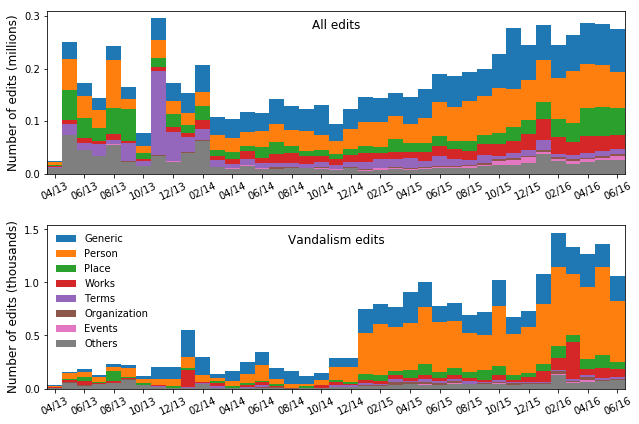

In [35]:
fig = plt.figure(figsize=(9, 6))

ax = fig.add_subplot(211)
fig = plot_group_statistics_over_time(ax, group_statistics, is_vandalism=False)

ax = fig.add_subplot(212)
fig = plot_group_statistics_over_time(ax, group_statistics_vandalism, is_vandalism=True)

fig.tight_layout()
fig.savefig(OUTPUT_DIR + 'plot-corpus-over-time.pdf', transparent=True, bbox_inches='tight')